<a href="https://colab.research.google.com/github/iwatadive28/ESC-50-1DCNN/blob/main/ESC_50_1DCNN_EdgeData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 環境の準備
Google Colabでの設定
Colabを開き、GPUを有効にします。
メニューから「ランタイム」 > 「ランタイムのタイプを変更」 > 「ハードウェア アクセラレータ」 > 「GPU」を選択。
必要なライブラリのインストール
以下を実行して、必要なライブラリをインストールします。



In [1]:
!pip install tensorflow librosa numpy matplotlib

# 2. データセットのダウンロード
ESC-50データセットをダウンロードして解凍します。

In [4]:
from google.colab import drive
import os
import zipfile
import urllib.request

# Google Driveをマウント
drive.mount('/content/drive')

# データセットの保存先フォルダをGoogle Drive内に設定
drive_data_dir = "/content/drive/MyDrive/Colab Notebooks/ESC-50-1DCNN_EdgeData"
os.makedirs(drive_data_dir, exist_ok=True)

# 保存先フォルダに移動
os.chdir(drive_data_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
"""
# ESC-50データセットのダウンロード
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
data_dir = "./ESC-50/"
zip_path = os.path.join(data_dir, "ESC-50.zip")

# データセットがまだダウンロードされていない場合のみダウンロード
if not os.path.exists(zip_path):
    print("データセットをダウンロード中...")
    urllib.request.urlretrieve(url, zip_path)
    print("ダウンロード完了！")

# 解凍
print("データセットを解凍中...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)

print("データセットの準備完了！")
"""

'\n# ESC-50データセットのダウンロード\nurl = "https://github.com/karoldvl/ESC-50/archive/master.zip"\ndata_dir = "./ESC-50/"\nzip_path = os.path.join(data_dir, "ESC-50.zip")\n\n# データセットがまだダウンロードされていない場合のみダウンロード\nif not os.path.exists(zip_path):\n    print("データセットをダウンロード中...")\n    urllib.request.urlretrieve(url, zip_path)\n    print("ダウンロード完了！")\n\n# 解凍\nprint("データセットを解凍中...")\nwith zipfile.ZipFile(zip_path, "r") as zip_ref:\n    zip_ref.extractall(data_dir)\n\nprint("データセットの準備完了！")\n'

# 3. 前処理
データとラベルの準備
フォルダ内の音声ファイルをロードします。
ラベルを抽出し、データを分割します。

In [47]:
import os
import csv
import numpy as np
from sklearn.model_selection import train_test_split

SAMPLE_RATE = 10000 # 10kHzサンプリングレート
DURATION = 1 # 音声の長さ（秒）

# CSVから音声データを読み込む関数
def load_csv_as_audio(csv_file_path, sample_rate=SAMPLE_RATE, duration=DURATION):
    try:
        with open(csv_file_path, 'r') as csv_file:
            reader = csv.reader(csv_file)
            data = next(reader)  # 1行目を取得

        # 数値に変換し、正規化
        audio_data = np.array([int(value) for value in data if value.strip()], dtype=np.float32)
        audio_data = audio_data / np.max(np.abs(audio_data))  # 正規化

        # 音声データの長さを統一（ゼロパディング）
        target_length = int(sample_rate * duration)
        if len(audio_data) < target_length:
            audio_data = np.pad(audio_data, (0, target_length - len(audio_data)))
        else:
            audio_data = audio_data[:target_length]

        return audio_data
    except Exception as e:
        raise ValueError(f"CSVファイルの読み込み時にエラーが発生しました: {e}")


In [48]:
# データの準備
def load_data_from_csv(base_dir, sample_rate=10000, duration=2.0):
    audio_data = []
    labels = []
    for class_name, label in zip(['clap', 'voice'], [0, 1]):
        class_path = os.path.join(base_dir, class_name)
        for file_name in os.listdir(class_path):
            if file_name.endswith('.csv'):
                csv_path = os.path.join(class_path, file_name)
                audio = load_csv_as_audio(csv_path, sample_rate, duration)
                audio_data.append(audio)
                labels.append(label)
    return np.array(audio_data), np.array(labels)

In [49]:
# データ拡張
def augment_audio_data(audio_data, labels, methods=["noise"], factor=5):
    augmented_data = []
    augmented_labels = []
    for y, lbl in zip(audio_data, labels):
        for _ in range(factor):
            for method in methods:
                if method == "noise":
                    noise = np.random.normal(0, 0.005, len(y))
                    augmented_data.append(y + noise)
                elif method == "volume":
                    augmented_data.append(y * np.random.uniform(0.8, 1.2))
                elif method == "pitch":
                    # ピッチシフトをCSVには適用しないため削除
                    pass
                augmented_labels.append(lbl)
    return np.array(augmented_data), np.array(augmented_labels)

In [54]:
from collections import Counter

# ラベル分布を表示する関数
def display_label_distribution(labels, message="データのラベル分布"):
    label_names = {0: "clap", 1: "voice"}  # ラベル名をマッピング
    label_counts = Counter(labels)

    print(f"\n{message}:")
    for label, count in label_counts.items():
        print(f"  {label_names[label]}: {count} サンプル")

In [56]:
# メイン処理
base_dir = "./sample_from_edge"
SAMPLE_RATE = 10000 # 10kHzサンプリングレート
DURATION = 1 # 音声の長さ（秒）

# データのロード
audio_data, labels = load_data_from_csv(base_dir, sample_rate, duration)


# データ拡張前のラベル分布を表示
display_label_distribution(labels, "データ拡張前の各ラベルのデータ数")


# データ拡張
augmented_audio, augmented_labels = augment_audio_data(audio_data, labels)


# データ拡張前のラベル分布を表示
display_label_distribution(augmented_labels, "データ拡張後の各ラベルのデータ数")

# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    np.vstack([audio_data, augmented_audio]),
    np.hstack([labels, augmented_labels]),
    test_size=0.2,
    random_state=42
)

# 結果表示
print(f"訓練データ: {len(X_train)} サンプル")
print(f"テストデータ: {len(X_test)} サンプル")


データ拡張前の各ラベルのデータ数:
  clap: 124 サンプル
  voice: 86 サンプル

データ拡張後の各ラベルのデータ数:
  clap: 620 サンプル
  voice: 430 サンプル
訓練データ: 1008 サンプル
テストデータ: 252 サンプル


In [57]:
from collections import Counter

# ラベル分布を表示する関数
def display_label_distribution(y_train, y_test):
    label_names = {0: "clap", 1: "voice"}  # ラベル名をマッピング
    # 訓練データのラベル分布
    train_counts = Counter(y_train)
    test_counts = Counter(y_test)

    print("\nラベル分布:")
    print("訓練データ:")
    for label, count in train_counts.items():
        print(f"  {label_names[label]}: {count} サンプル")
    print("テストデータ:")
    for label, count in test_counts.items():
        print(f"  {label_names[label]}: {count} サンプル")

# ラベル分布の表示
display_label_distribution(y_train, y_test)



ラベル分布:
訓練データ:
  clap: 588 サンプル
  voice: 420 サンプル
テストデータ:
  clap: 156 サンプル
  voice: 96 サンプル


---

# 4. モデル構築
1D-CNNを使用したモデルを構築します。

In [17]:
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

# ラベルをエンコード
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# パラメータ設定（整数型に変換）
INPUT_LENGTH = int(SAMPLE_RATE * DURATION)  # 整数型に変換

# モデル構築
model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(INPUT_LENGTH, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(encoder.classes_), activation='softmax')
])

# モデルのコンパイル
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 9998, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4999, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 4997, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 2498, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 2496, 256)           │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,674 (612.01 KB)

 Trainable params: 156,674 (612.01 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
!pip install pydot graphviz

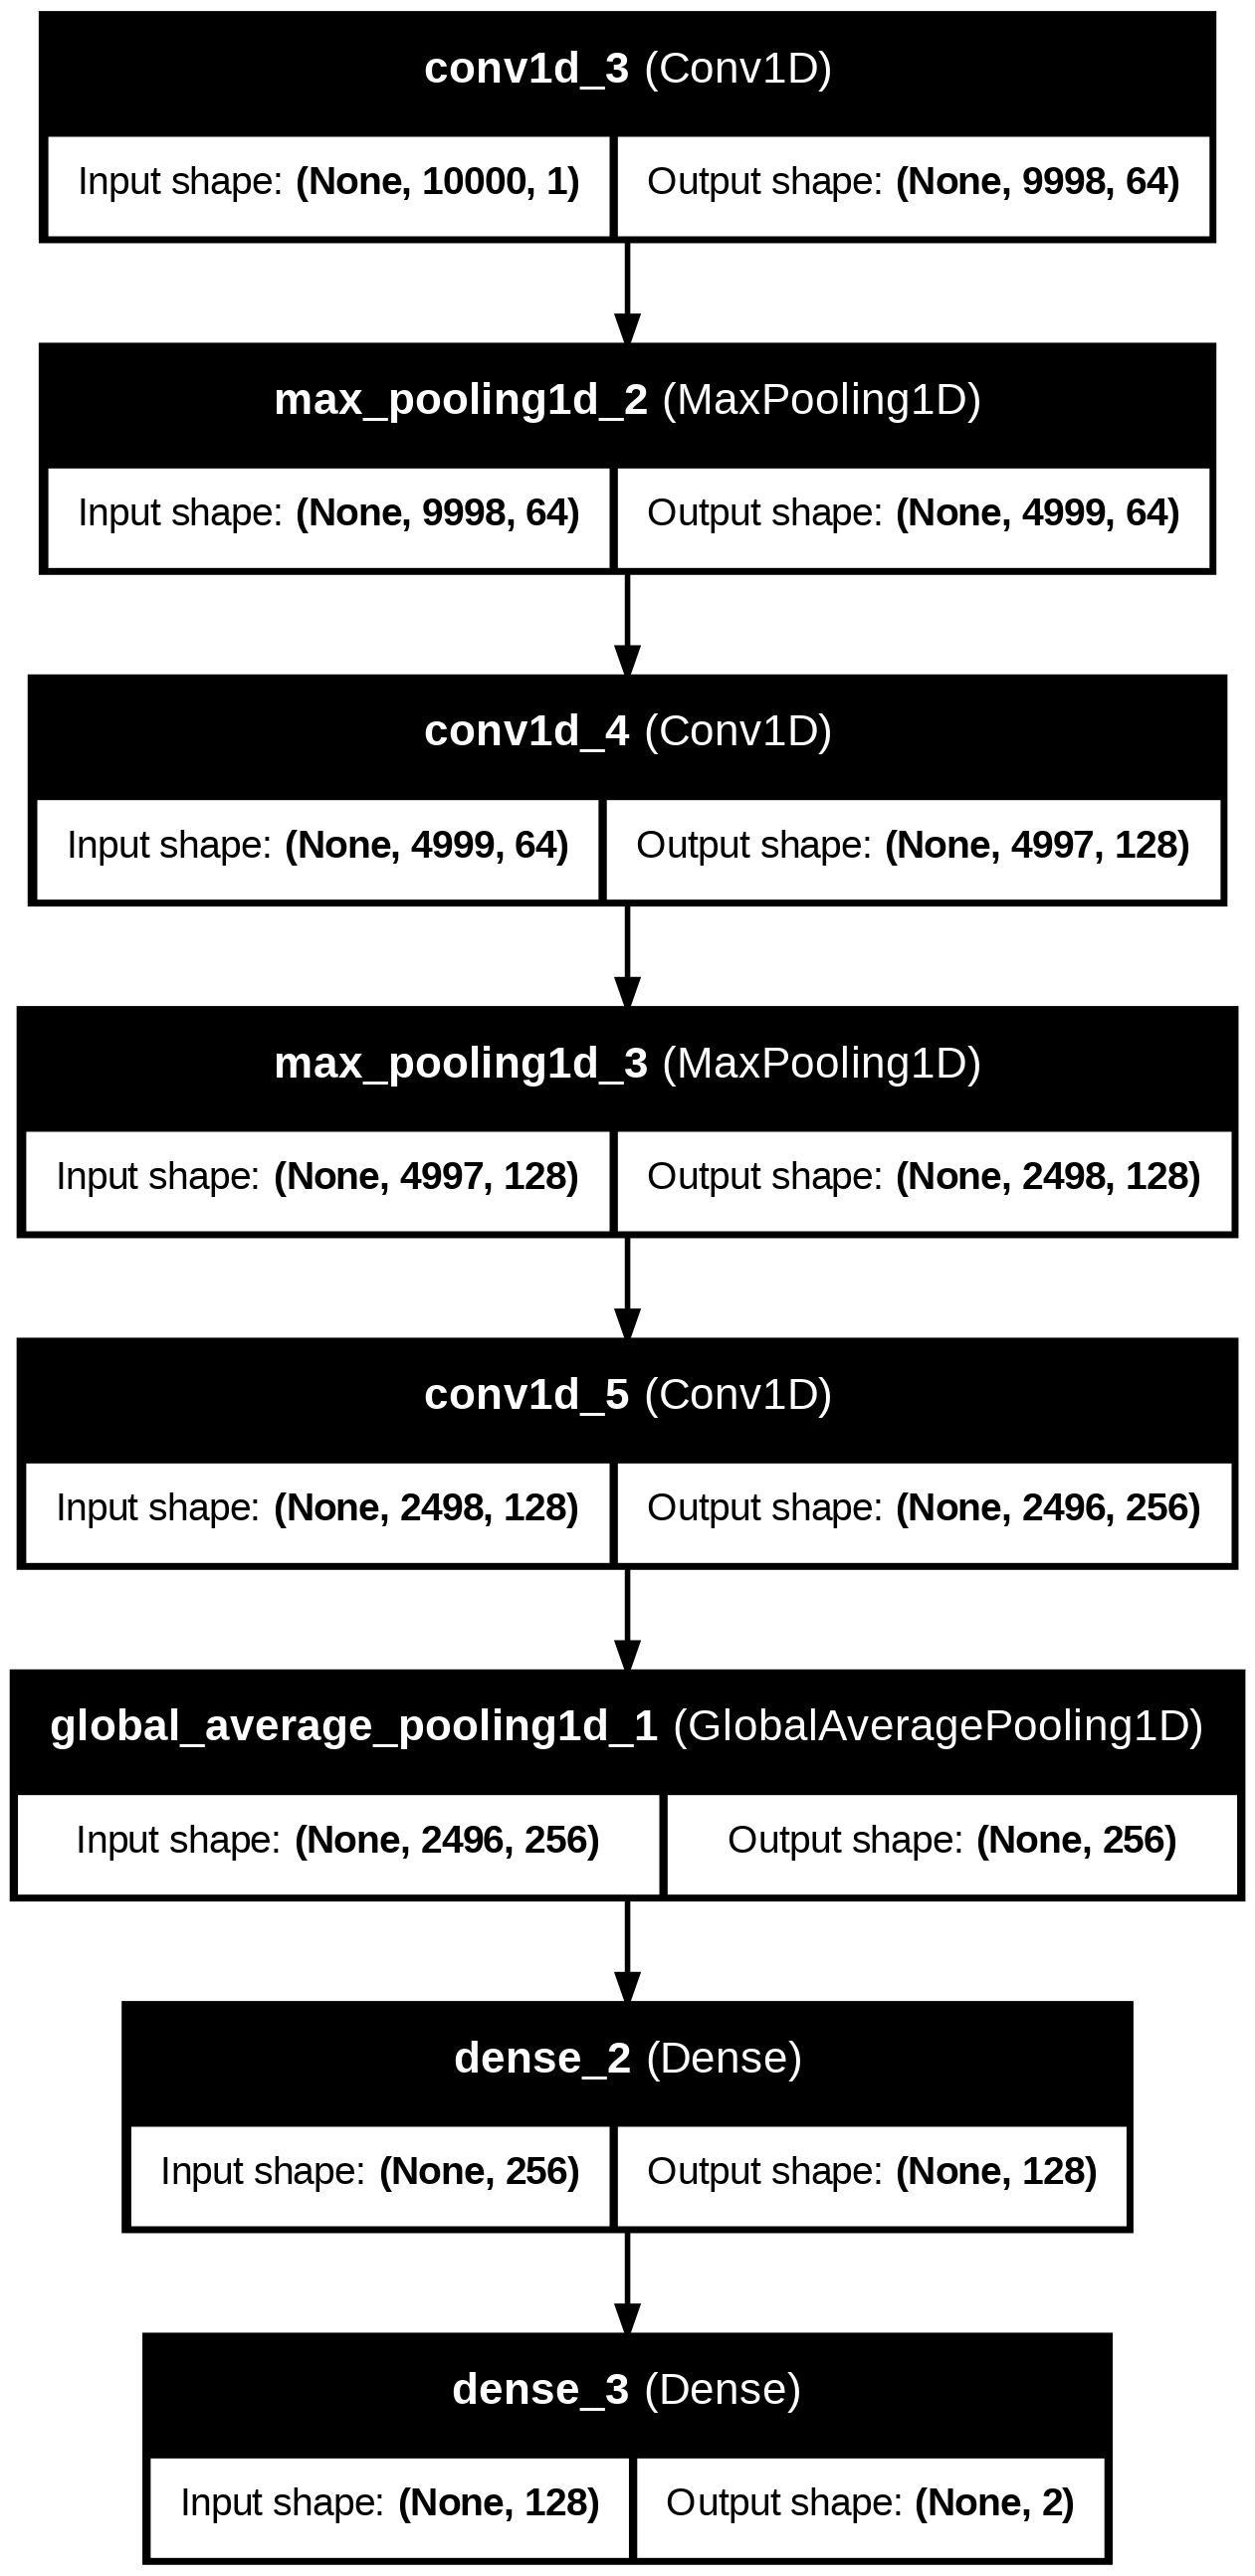

In [19]:
from tensorflow.keras.utils import plot_model
# モデル構造図の表示
plot_model(
    model,
    to_file="model_structure.png",  # ファイルに保存
    show_shapes=True,  # 入力と出力の形状を表示
    show_layer_names=True  # レイヤー名を表示
)

# Notebook内で画像を表示（小さく表示）
from IPython.display import Image
Image("model_structure.png", width=400)  # 幅を400ピクセルに指定


# 5. データの準備と訓練
データをモデルに適した形式に変換して訓練します。

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# データの形状を確認
print(f"X_train shape before reshaping: {np.array(X_train).shape}")
print(f"y_train_enc shape: {np.array(y_train_enc).shape}")

# 入力データの形状を修正
X_train = np.array(X_train).reshape(-1, SAMPLE_RATE * DURATION, 1)
X_test = np.array(X_test).reshape(-1, SAMPLE_RATE * DURATION, 1)

# ラベルをNumPy配列に変換
y_train_enc = np.array(y_train_enc)
y_test_enc = np.array(y_test_enc)

# 修正後の形状を確認
print(f"X_train shape after reshaping: {X_train.shape}")
print(f"y_train_enc shape: {y_train_enc.shape}")

# モデルの保存先パス
MODEL_SAVE_PATH = "trained_1d_cnn_model.keras"

# モデルの訓練時に保存するコールバック
# EarlyStopping と ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# モデルの訓練
history = model.fit(
    X_train,
    y_train_enc,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test_enc),
    callbacks=[checkpoint, early_stopping]
)

# 最終モデルの保存
model.save(MODEL_SAVE_PATH)
print(f"モデルを保存しました: {MODEL_SAVE_PATH}")

X_train shape before reshaping: (1008, 10000)
y_train_enc shape: (1008,)
X_train shape after reshaping: (1008, 10000, 1)
y_train_enc shape: (1008,)
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4669 - loss: 0.6957
Epoch 1: val_loss improved from inf to 0.67348, saving model to trained_1d_cnn_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.4683 - loss: 0.6956 - val_accuracy: 0.6190 - val_loss: 0.6735
Epoch 2/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6485 - loss: 0.6511
Epoch 2: val_loss improved from 0.67348 to 0.32448, saving model to trained_1d_cnn_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.6537 - loss: 0.6465 - val_accuracy: 0.9167 - val_loss: 0.3245
Epoch 3/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8991 - loss: 0.3299
Epoch 3: val_loss did not improve from 0.32448
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9005 - loss: 0.3260 - val_accuracy: 0.8254 - val_loss: 0.5371
Epoch 4/50
31

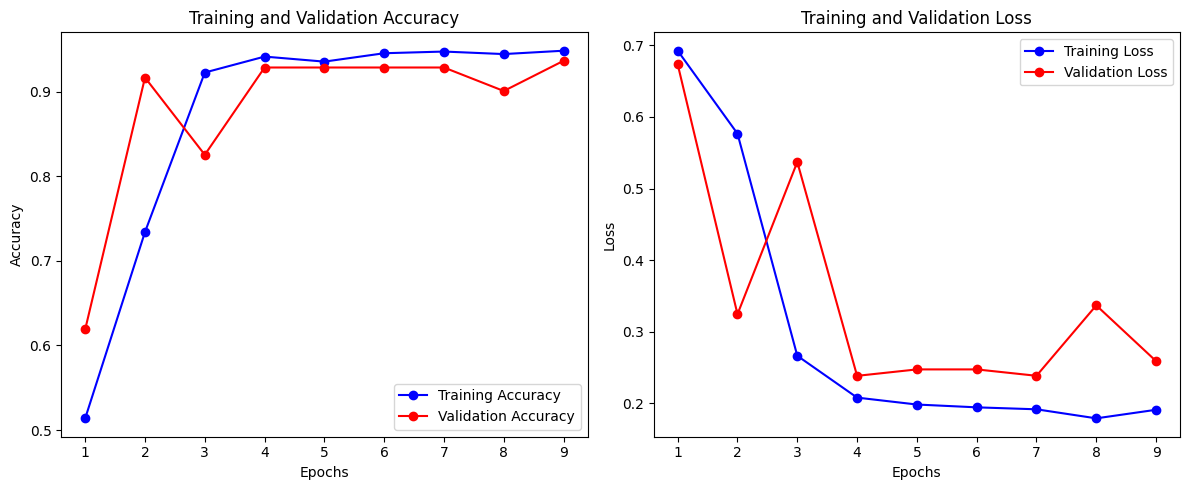

In [23]:
import matplotlib.pyplot as plt

# 訓練履歴を可視化
def plot_training_history(history):
    """AccuracyとLossのグラフを表示"""
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Accuracyのプロット
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Lossのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# グラフを表示
plot_training_history(history)


In [24]:
import time
import os
import tensorflow as tf

# モデルの保存先パス
MODEL_SAVE_PATH = "trained_1d_cnn_model.keras"

# モデルサイズの計測
def calculate_model_size(model, save_path=MODEL_SAVE_PATH):
    # model.save(save_path)  # 一時的にモデルを保存
    model_size = os.path.getsize(save_path) / (1024 * 1024)  # サイズをMB単位で計測
    # os.remove(save_path)  # 保存したモデルを削除
    return model_size

# 推論時間の計測
def measure_inference_time(model, sample_input, num_trials=100):
    """
    モデル推論の時間を計測
    - model: 計測するモデル
    - sample_input: モデルへの入力データ
    - num_trials: 推論を繰り返す回数
    """
    # TensorFlowのキャッシュをクリア
    tf.keras.backend.clear_session()

    # 推論の時間を計測
    start_time = time.time()
    for _ in range(num_trials):
        _ = model.predict(sample_input, verbose=0)
    total_time = time.time() - start_time
    avg_time = total_time / num_trials
    return avg_time

# モデルサイズの評価
model_size = calculate_model_size(model)
print(f"モデルサイズ: {model_size:.2f} MB")

# 推論時間の評価
# サンプル入力データの作成（1秒の音声データを想定）
sample_input = tf.random.normal((1, SAMPLE_RATE * DURATION, 1))  # バッチサイズ1の入力
inference_time = measure_inference_time(model, sample_input)
print(f"1サンプルあたりの平均推論時間: {inference_time:.4f} 秒")


モデルサイズ: 1.83 MB
1サンプルあたりの平均推論時間: 0.0500 秒


# 6. モデルの評価
保存形式が.kerasの場合も.h5の場合も、以下の方法でロードできます。
テストデータでモデルの性能を評価します。

In [25]:
from tensorflow.keras.models import load_model

# 保存済みモデルのロード
loaded_model = load_model(MODEL_SAVE_PATH)
print("モデルをロードしました。")
loaded_model.summary()


# テストデータで評価
test_loss, test_acc = model.evaluate(X_test, y_test_enc)
print(f"テストデータの損失: {test_loss}")
print(f"テストデータの精度: {test_acc}")


モデルをロードしました。


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 9998, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4999, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 4997, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 2498, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 2496, 256)           │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 470,024 (1.79 MB)

 Trainable params: 156,674 (612.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 313,350 (1.20 MB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9470 - loss: 0.1805
テストデータの損失: 0.23836059868335724
テストデータの精度: 0.9285714030265808


# 7. 推論
新しい音声データをモデルで分類します。

In [31]:
# 推論関数
def predict_audio(file_path):
    # CSVファイルをロードして音声データとして処理
    y = load_csv_as_audio(file_path, SAMPLE_RATE, DURATION)
    # モデルに入力できる形にリシェイプ
    y = y.reshape(1, -1, 1)
    # 推論
    predictions = model.predict(y)
    # ラベルをデコード
    predicted_label = encoder.inverse_transform([np.argmax(predictions)])
    return predicted_label[0]

# 推論例
test_file = "./sample_from_edge/clap/log_2024-12-31_18-02-48.csv"
print(f"推論結果: {predict_audio(test_file)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
推論結果: 0


In [32]:
import random
import os

# ディレクトリと設定
BASE_DIR = "./sample_from_edge/"
CLASSES = ["clap", "voice"]  # クラス名
N = 3  # ランダムに選ぶファイル数

# 音声ファイルのランダム選択とラベルの取得
def list_random_files_with_labels(base_dir, classes, n):
    """指定されたディレクトリからランダムにN個の音声ファイルとラベルをリストアップする"""
    selected_files_with_labels = []

    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"ディレクトリが存在しません: {class_dir}")
            continue

        # 指定クラスの音声ファイルを取得
        audio_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(".csv")]

        # 音声ファイルが少ない場合の例外処理
        if len(audio_files) < n:
            print(f"クラス '{class_name}' には {n} 個のファイルがありません。全ファイルを使用します。")
            n = len(audio_files)

        # ランダムに選択
        selected_files = random.sample(audio_files, n)

        # ファイルとラベルをリストに追加
        for file_path in selected_files:
            selected_files_with_labels.append((file_path, class_name))  # クラス名をラベルとして追加

    return selected_files_with_labels

# ランダムに音声ファイルとラベルを取得
selected_files_with_labels = list_random_files_with_labels(BASE_DIR, CLASSES, N)

# 結果の表示
for file_path, label in selected_files_with_labels:
    print(f"File: {file_path}, Label: {label}")


File: ./sample_from_edge/clap/log_2024-12-31_18-05-23.csv, Label: clap
File: ./sample_from_edge/clap/log_2024-12-31_18-05-47.csv, Label: clap
File: ./sample_from_edge/clap/log_2024-12-31_18-04-01.csv, Label: clap
File: ./sample_from_edge/voice/log_2024-12-31_18-13-48.csv, Label: voice
File: ./sample_from_edge/voice/log_2024-12-31_18-14-55.csv, Label: voice
File: ./sample_from_edge/voice/log_2024-12-31_18-13-43.csv, Label: voice


選ばれた音声ファイル:
1: ./sample_from_edge/clap/log_2024-12-31_18-05-23.csv (Label: clap)
2: ./sample_from_edge/clap/log_2024-12-31_18-05-47.csv (Label: clap)
3: ./sample_from_edge/clap/log_2024-12-31_18-04-01.csv (Label: clap)
4: ./sample_from_edge/voice/log_2024-12-31_18-13-48.csv (Label: voice)
5: ./sample_from_edge/voice/log_2024-12-31_18-14-55.csv (Label: voice)
6: ./sample_from_edge/voice/log_2024-12-31_18-13-43.csv (Label: voice)


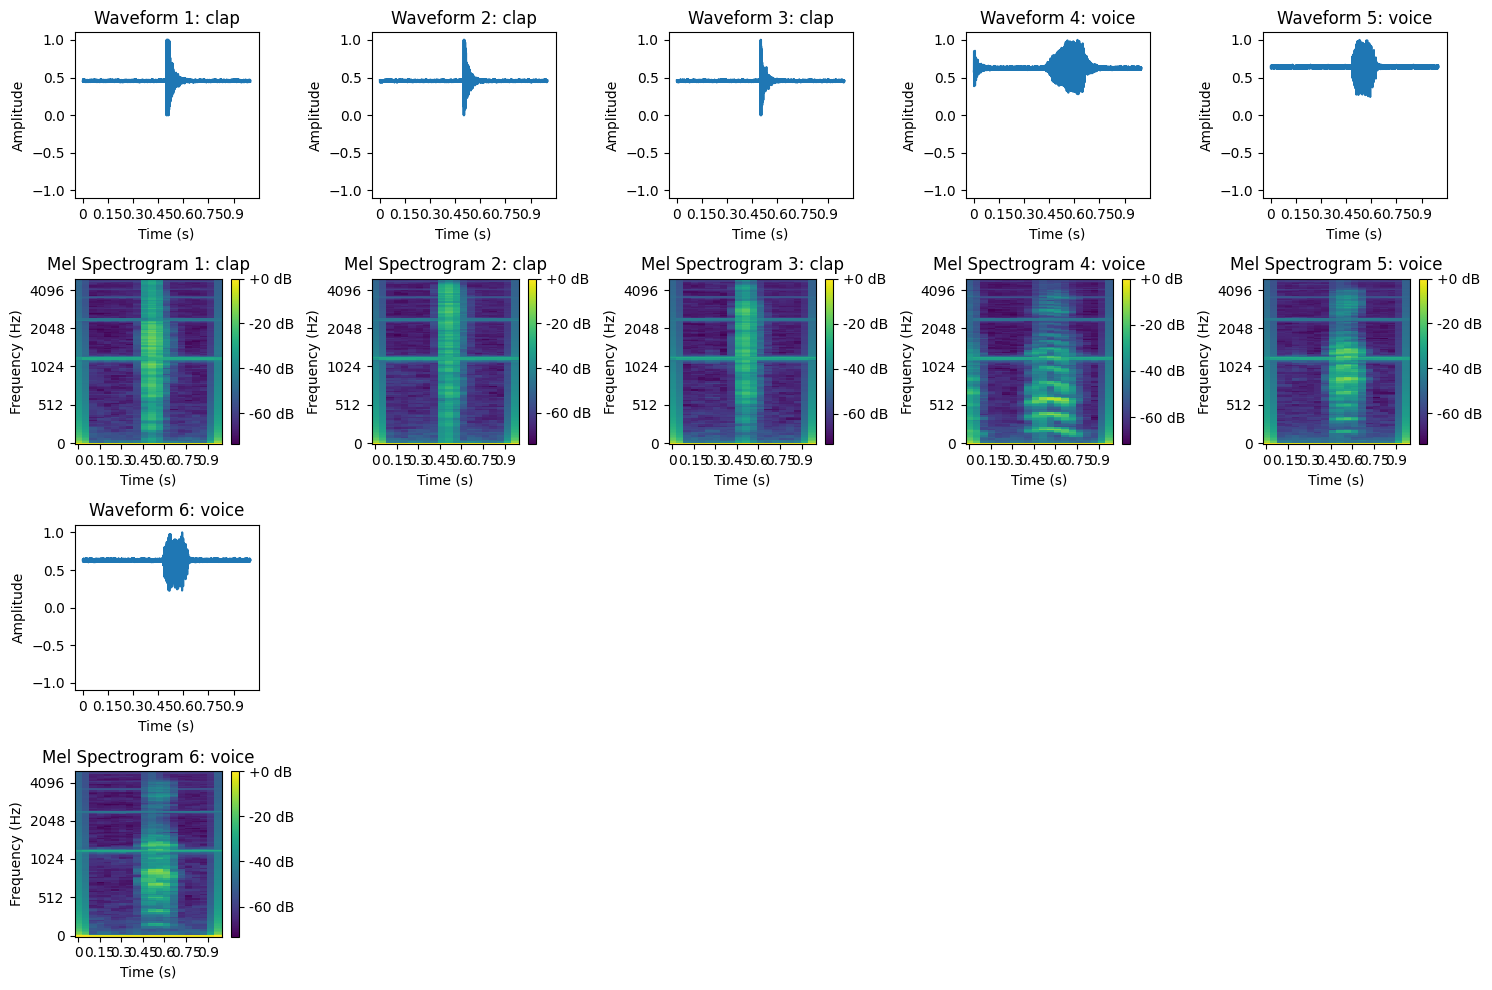

Audio Playback: ./sample_from_edge/clap/log_2024-12-31_18-05-23.csv (Label: clap)


Audio Playback: ./sample_from_edge/clap/log_2024-12-31_18-05-47.csv (Label: clap)


Audio Playback: ./sample_from_edge/clap/log_2024-12-31_18-04-01.csv (Label: clap)


Audio Playback: ./sample_from_edge/voice/log_2024-12-31_18-13-48.csv (Label: voice)


Audio Playback: ./sample_from_edge/voice/log_2024-12-31_18-14-55.csv (Label: voice)


Audio Playback: ./sample_from_edge/voice/log_2024-12-31_18-13-43.csv (Label: voice)


In [34]:
import csv
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Audio, display


# CSVファイルから波形データを読み込む関数
def load_csv_as_audio(file_path, sample_rate=10000, duration=None):
    with open(file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        data = next(reader)

    # 数値データに変換
    audio_data = np.array([int(value) for value in data if value.strip()], dtype=np.float32)
    audio_data = audio_data / np.max(np.abs(audio_data))  # 正規化

    # 長さを統一（ゼロパディングまたは切り詰め）
    if duration:
        target_length = int(sample_rate * duration)
        if len(audio_data) < target_length:
            audio_data = np.pad(audio_data, (0, target_length - len(audio_data)))
        else:
            audio_data = audio_data[:target_length]

    return audio_data, sample_rate

# プロット関数
def plot_audio_and_spectrograms(file_paths_with_labels, max_columns=5, sample_rate=10000):
    num_files = len(file_paths_with_labels)
    num_rows = (num_files + max_columns - 1) // max_columns

    plt.figure(figsize=(15, 5 * num_rows))

    for idx, (file_path, label) in enumerate(file_paths_with_labels):
        # CSVファイルから音声データを読み込む
        y, sr = load_csv_as_audio(file_path, sample_rate)

        # スペクトログラムの計算
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # プロット位置の計算
        row = idx // max_columns
        col = idx % max_columns

        # 波形プロット
        plt.subplot(num_rows * 2, max_columns, row * max_columns * 2 + col + 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f"Waveform {idx + 1}: {label}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # スペクトログラムプロット
        plt.subplot(num_rows * 2, max_columns, row * max_columns * 2 + max_columns + col + 1)
        librosa.display.specshow(log_spectrogram, sr=sr, x_axis="time", y_axis="mel", cmap="viridis")
        plt.title(f"Mel Spectrogram {idx + 1}: {label}")
        plt.colorbar(format="%+2.0f dB")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

    # 音声の再生
    for file_path, label in file_paths_with_labels:
        print(f"Audio Playback: {file_path} (Label: {label})")
        y, sr = load_csv_as_audio(file_path, sample_rate)
        display(Audio(y, rate=sr))

# サンプルデータ（selected_files_with_labels）を使用して実行
print("選ばれた音声ファイル:")
for idx, (file_path, label) in enumerate(selected_files_with_labels, 1):
    print(f"{idx}: {file_path} (Label: {label})")

plot_audio_and_spectrograms(selected_files_with_labels)


In [37]:
# 推論関数
def predict_audio(file_path):
    # CSVファイルから音声データを読み込む（`audio_data` のみ使用）
    y, _ = load_csv_as_audio(file_path, SAMPLE_RATE, DURATION)
    # モデルに入力できる形にリシェイプ
    y = y.reshape(1, -1, 1)
    # 推論
    predictions = model.predict(y)
    # ラベルをデコード
    predicted_label = encoder.inverse_transform([np.argmax(predictions)])
    return predicted_label[0]

# 修正後の推論ループ
for idx, (file_path, label) in enumerate(selected_files_with_labels, 1):
    print(f"{idx}: {file_path} (Label: {label})")
    print(f"推論結果: {predict_audio(file_path)}")


1: ./sample_from_edge/clap/log_2024-12-31_18-05-23.csv (Label: clap)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
推論結果: 0
2: ./sample_from_edge/clap/log_2024-12-31_18-05-47.csv (Label: clap)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
推論結果: 0
3: ./sample_from_edge/clap/log_2024-12-31_18-04-01.csv (Label: clap)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
推論結果: 0
4: ./sample_from_edge/voice/log_2024-12-31_18-13-48.csv (Label: voice)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
推論結果: 1
5: ./sample_from_edge/voice/log_2024-12-31_18-14-55.csv (Label: voice)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
推論結果: 1
6: ./sample_from_edge/voice/log_2024-12-31_18-13-43.csv (Label: voice)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
推論結果: 1


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


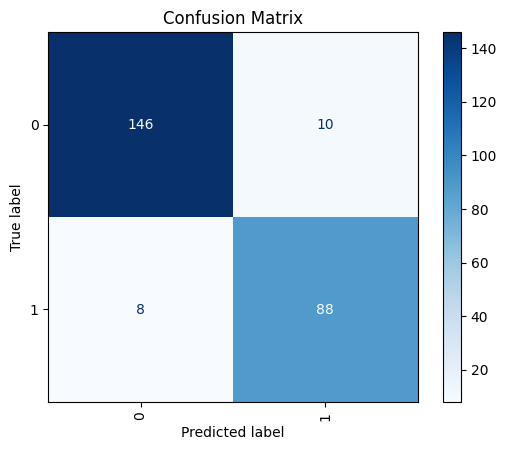

'\n訓練データ:\n  clap: 588 サンプル\n  voice: 420 サンプル\nテストデータ:\n  clap: 156 サンプル\n  voice: 96 サンプル\n'

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 予測ラベルの取得
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 混同行列の計算
cm = confusion_matrix(y_test_enc, y_pred_classes, labels=range(len(encoder.classes_)))

# 混同行列の表示
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()
"""
訓練データ:
  clap: 588 サンプル
  voice: 420 サンプル
テストデータ:
  clap: 156 サンプル
  voice: 96 サンプル
"""

# スタンドアローンで動作するコード
今後、別のインスタンスに移行する予定。